In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
%reload_ext autoreload
import sys

sys.path.append('..')

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import spacy
import re
import json
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from helpers.utils import (
    tokenize,
    filter_stop_words
)

# progress bar
tqdm.pandas()

In [3]:
nlp_core = spacy.load("pl_core_news_lg")

stopwords = nlp_core.Defaults.stop_words

## Load data

In [96]:
df = pd.read_parquet('../datasets/ready2use/fake_news_features_combined.parquet')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 1,
#     'Manipulacja' : 1,
    'Prawda' : 0
}).astype(int)

y_train = df.copy()['assestment']
X_train = df.copy().loc[:, df.columns != 'assestment']

In [97]:
y_train.value_counts()

assestment
1    3439
0    3103
Name: count, dtype: int64

## Analysis words frequencies

In [98]:
X_train['words']  = X_train['text_clean'].progress_map(lambda x: tokenize(txt=x, nlp_core=nlp_core, stopwords=stopwords))

X_train = X_train[X_train['words'].apply(len)>0]
y_train = y_train[y_train.index.isin(X_train.index)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6542/6542 [00:42<00:00, 152.85it/s]


In [99]:
df_one = X_train.copy()

df_one = df_one[['words']].reset_index().explode('words')
df_one['n'] = 1
df_one['tokens'] = df_one['words'].apply( lambda x: re.sub(r"[`'-.’0-9]", "", x) )
df_one['class'] = y_train

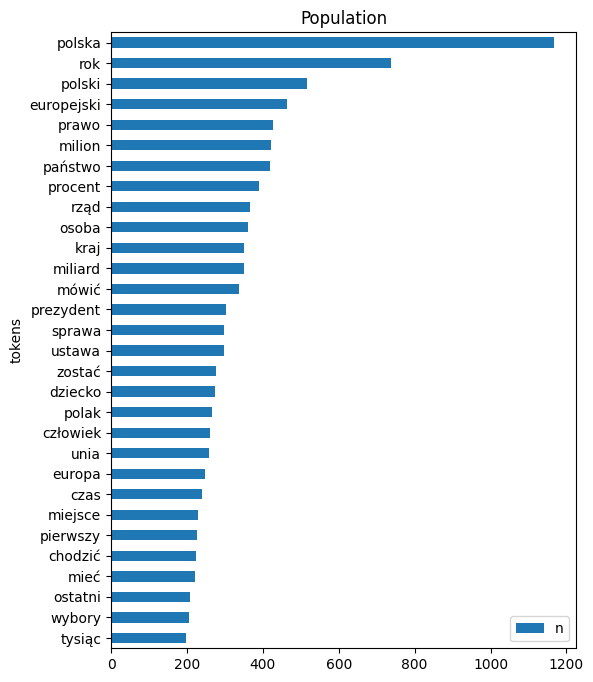

In [100]:
df_one = df_one[df_one['tokens'].str.len() > 1]

f, ax = plt.subplots(figsize=(6,8))
df_one.groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Population')
plt.show()

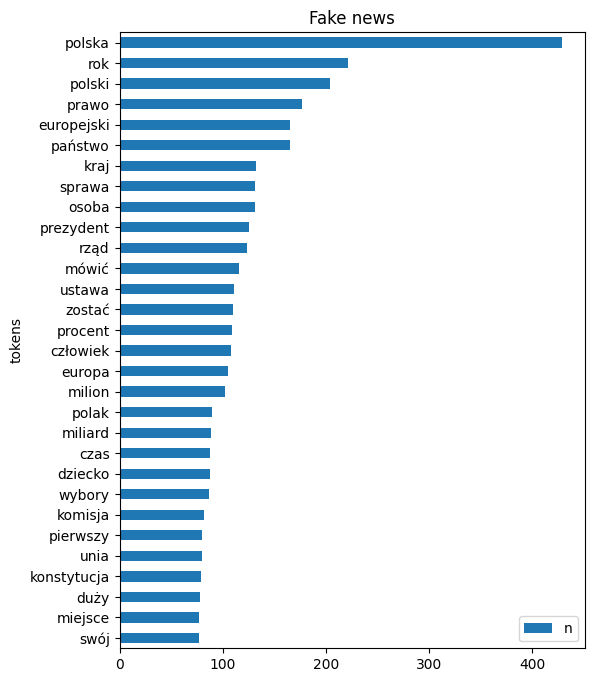

In [101]:
f, ax = plt.subplots(figsize=(6,8))
df_one[df_one['class']==1].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Fake news')
plt.show()

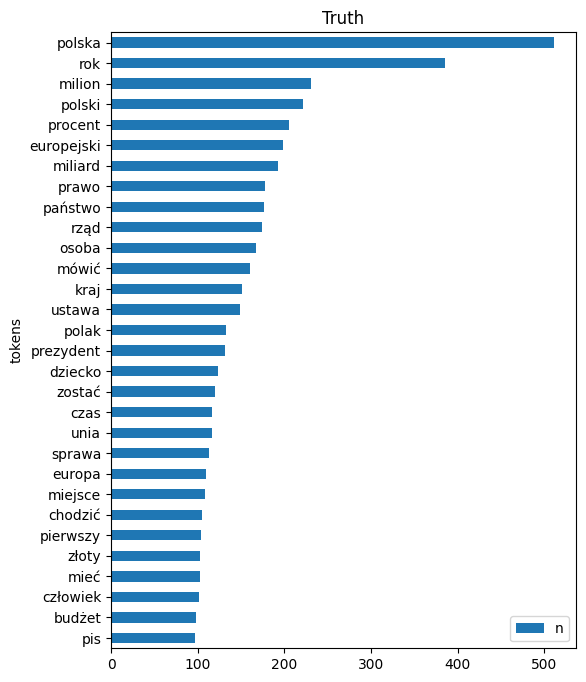

In [102]:
f, ax = plt.subplots(figsize=(6,8))
df_one[df_one['class']==0].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(30).plot(kind='barh', ax=ax)
plt.title('Truth')
plt.show()

In [103]:
top_words_1 = df_one[df_one['class']==1].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(25).index.values

top_words_0 = df_one[df_one['class']==0].groupby('tokens').agg(n=('n','sum')).sort_values('n').tail(25).index.values

np.sort(top_words_1[np.isin(top_words_1, top_words_0)]) == np.sort(top_words_0[np.isin(top_words_0, top_words_1)])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [104]:
np.sort(top_words_1[np.isin(top_words_1, top_words_0)])

array(['czas', 'dziecko', 'europa', 'europejski', 'kraj', 'miliard',
       'milion', 'mówić', 'osoba', 'państwo', 'pierwszy', 'polak',
       'polska', 'polski', 'prawo', 'prezydent', 'procent', 'rok', 'rząd',
       'sprawa', 'ustawa', 'zostać'], dtype=object)

## Extra stopwords

In [105]:
extra_stop_words = set(['polska', 
                        'rok', 
                        'polski', 
                        # 'europejski', 'milion',
                        # 'prawo', 'państwo', 
                        # 'procent', 'rząd', 'miliard', 'osoba', 'kraj', 
                        # 'mówić', 'zostać'
                       ] 
                       + 
                       df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist())

# extra_stop_words = set(
#     np.sort(top_words_1[np.isin(top_words_1, top_words_0)]).tolist()
#     + df_one.groupby('tokens').agg(n=('n','sum')).query('n<6').index.values.tolist()
# )

In [106]:
len(extra_stop_words)

10445

In [107]:
extra_stop_words_dict = {'extra_stop_words' : list(extra_stop_words)}

In [108]:
with open("../datasets/ready2use/extra_stop_words.json", "w") as fp:
    json.dump(extra_stop_words_dict, fp) 

## Exclude extra stopwords

In [109]:
X_train['words_clean']  = X_train['words'].progress_map(lambda x: filter_stop_words(words=x, stop_words=extra_stop_words))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6541/6541 [00:00<00:00, 391011.67it/s]


## WordCloud

In [110]:
df_wc = X_train.copy()

df_wc['words_clean_join'] = df_wc['words_clean'].apply(lambda x: ' '.join(x))
df_wc['words_join'] = df_wc['words'].apply(lambda x: ' '.join(x))
df_wc['assestment'] = y_train
df_wc = df_wc[['words_clean', 'words_clean_join', 'assestment', 'words', 'words_join']]

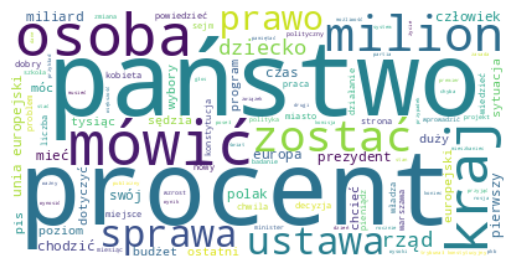

In [111]:
# Start with one review:
text = " ".join(w for w in df_wc['words_clean_join'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=[], background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

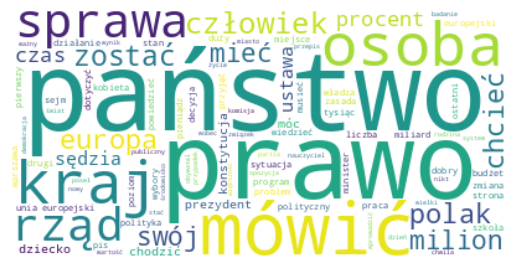

In [112]:
# Start with one review:
text = " ".join(w for w in df_wc['words_clean_join'][df_wc['assestment']==1])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=[], background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

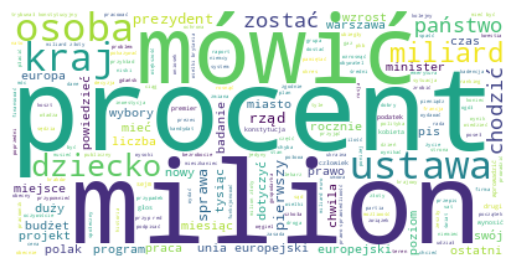

In [113]:
# Start with one review:
text = " ".join(w for w in df_wc['words_clean_join'][df_wc['assestment']==0])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=[], background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis of words (with which label the coexist)

In [ ]:
# https://realpython.com/python-nltk-sentiment-analysis/